# **BISICLES Glacial Model Assessment Tool (BGMAT)**

Welcome to BGMAT, a tool built to visualise and assess the accuracy of the BISICLES Glacial Model. This tool allows a user to compare glacial frontiers over time with geomorphological evidence (e.g., Moraine data) to determine how well a BISICLES model experiment is able to predict glacial movements. One can also use this tool over multiple BISICLES models to establish which model has the highest predictive power (Given by the RSME values).

To ensure this program runs properly, please follow these key steps:

1. All raw data files must be in the same file directory.
2. All raw data files must be in the correct format (e.g., Moraine data must be saved as .xlsx)
3. All netCDF files should have the common plot data variable (i.e., ice thickness)
4. The coordinates .mat file should contain a 'lat' and 'lon' variable
5. The moraine data should have columns 'SiteName', 'latitude','longitude','Age','Uncertainty'
6. The variables listed above should be in the correct spelling
7. Ensure that all installations have been computed before running the program
8. Wait for the "You have successfully ran BGMAT" message to pop up to interact with plots
9. When running BGMAT for the first time, make sure that all hashtags are removed from conda and pip installations. readd them once you have installed them. They will not need to be redownlaoded.
10. An optional extra is to to use the Nbextensions functionality in Jupyter to hide the code when running for a        nicer UI

**Warning** This code has been specialised for the research project associated in regard to the treatment of the coordinate variable file. The file contained errors where the lat was stated as the lon variable and vice versa. Also, lon variable was inverted where higher lonitude values were at the bottom of the matrix. Make sure these issues are considered when redering coordinate variables. Find the code segment below and modify where necessary.

    # Extract the longitude and latitude variables from the .mat file
    longitude = matlab_data['lat'].squeeze()
    latitude = matlab_data['lon'].squeeze()

    lon = longitude[-1, :]
    lat = latitude[:, 0]

**Warning** On a further note, SFC values have also been manipulated for the sake of the research project. Find this segment of code and modify where necessary.

    # Extract the coordinate variable 'sfc'
    end_year = -10000
    yearly_increment = -100
    start_year = (len(dataset['sfc'].values)*yearly_increment)+(end_year-yearly_increment)
    sfc = list(range(start_year, end_year+1, - yearly_increment))

In [1]:
#!conda update -n base -c defaults conda --yes
#!conda install xarray --yes
#!conda install netcdf4 --yes
#!conda install cartopy --yes
#!conda install basemap --yes
#!conda install numpy --yes
#!pip install pyproj
#!pip install pandas openpyxl
#!pip install geopy
#!pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install --user
#!pip install jupyter_nbextensions_configurator &&  jupyter nbextensions_configurator enable --user
#!conda install -c conda-forge jupyter_contrib_nbextensions --yes
#!pip install imageio pillow
#!pip install --upgrade imageio

In [2]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as crrs
from mpl_toolkits.basemap import Basemap
import scipy.io
from scipy.io import loadmat
import pandas as pd
from pyproj import CRS, Transformer
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
import random
from matplotlib.widgets import Slider
import ipywidgets as widgets
from ipywidgets import interact, VBox, HBox, FloatSlider, Dropdown, Button
from IPython.display import display, clear_output
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as patches
import matplotlib.ticker as mticker
from geopy.distance import geodesic
import matplotlib.colors as mcolors
from scipy.spatial import distance
from scipy.interpolate import RegularGridInterpolator
from IPython.display import display
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata
from scipy.interpolate import RectBivariateSpline
from shapely.geometry import Point
from shapely.ops import nearest_points
from scipy.spatial import cKDTree
from matplotlib import path
from scipy.optimize import minimize_scalar
from matplotlib.path import Path
import warnings
import matplotlib.patches as patches
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
import os
import imageio
from PIL import Image
import io
import imageio.v2 as imageio

In [3]:
netCDF = []

# Prompt the user to enter a file directory, and keep prompting if no value was entered or the directory doesn't exist
while True:
    path = input("Please enter the file directory (Press Enter to input): ")
    
    if path and os.path.isdir(path):  # Check if a value was entered and if the directory exists
        break
    
    print()
    print(f"\033[91mThe directory you entered is invalid or does not exist. Please try again.\033[0m")

# Append a backslash to the end of the path if there isn't one already
if not path.endswith('/'):
    path += '/'

print()

print(f"\033[1;92mThe directory you entered is: {path}\033[0m")

# Loop to add netCDF files to the list
while True:
    while True:
        print()
        netcdf_file = input("What is the name of the model netCDF file? (include .nc at the end): ")
        
        if not netcdf_file.endswith('.nc'):
            print(f"\033[91mThe file you entered is not a netCDF file. Please enter a file with the .nc extension.\033[0m")
            continue
            
        if netcdf_file in netCDF:
            print(f"\033[91mThis netCDF file is already in the list.\033[0m")
            break
        
        full_path = os.path.join(path, netcdf_file)

        if os.path.isfile(full_path):
            netCDF.append(netcdf_file)
            break 
        else:
            print(f"\033[91mnetCDF file not found, please enter the correct name (include .nc at the end).\033[0m")
    
    while True:
        print()
        another = input("Do you have another netCDF file you would like to add? (Y/N): ").strip().upper()
        
        if another in ['Y', 'N']:
            break
        else:
            print(f"\033[91mInvalid input. Please enter 'Y' for Yes or 'N' for No.\033[0m")
    
    if another != 'Y':
        print()
        break

print(f"\033[1;92mThe netCDF files are: {netCDF}\033[0m")

# Prompt the user for the MATLAB coordinates file
while True:
    print()
    matlab_file = input("What is the name of the coordinates MATLAB file? (include .mat at the end): ")

    if not matlab_file.endswith('.mat'):
        print(f"\033[91mThe file you entered is not a MATLAB file. Please enter a file with the .mat extension.\033[0m")
        continue

    full_matlab_path = os.path.join(path, matlab_file)

    if os.path.isfile(full_matlab_path):
        break
    else:
        print(f"\033[91mMATLAB file not found, please enter the correct name (include .mat at the end).\033[0m")

print()
print(f"\033[1;92mThe MATLAB coordinates file you entered is: {matlab_file}\033[0m")

# Load the Coordinate MATLAB .mat file
matlab_data = scipy.io.loadmat(full_matlab_path)

# Extract the longitude and latitude variables from the .mat file
longitude = matlab_data['lat'].squeeze()
latitude = matlab_data['lon'].squeeze()

lon = longitude[-1, :]   # Assuming longitude is 2D
lat = latitude[:, 0]    # Assuming latitude is 2D
print()

# Prompt the user for the Morraines data file
while True:
    print()
    moraines_file = input("What is the name of the Morraines data file? (include .xlsx at the end): ")

    if not moraines_file.endswith('.xlsx'):
        print(f"\033[91mThe file you entered is not an xlsx file. Please enter a file with the .xlsx extension.\033[0m")
        continue

    full_moraines_path = os.path.join(path, moraines_file)

    if os.path.isfile(full_moraines_path):
        break
    else:
        print(f"\033[91mMorraines data file not found, please enter the correct name (include .xlsx at the end).\033[0m")

print()
print(f"\033[1;92mThe Morraines data file you entered is: {moraines_file}\033[0m")

# Load the Moraine Excel .xlsx file
excel = pd.read_excel(full_moraines_path)

print()
print(f"\033[1;92mYou have succesfully imported all necessary files.\033[0m")

Please enter the file directory (Press Enter to input): /Users/justkikas/Documents/Documents - Benonio’s MacBook Pro/Durham University/Research Project/Raw Data Files

The directory you entered is: /Users/justkikas/Documents/Documents - Benonio’s MacBook Pro/Durham University/Research Project/Raw Data Files/

What is the name of the model netCDF file? (include .nc at the end): exp853.nc

Do you have another netCDF file you would like to add? (Y/N): Y

What is the name of the model netCDF file? (include .nc at the end): exp753.nc

Do you have another netCDF file you would like to add? (Y/N): N

The netCDF files are: ['exp853.nc', 'exp753.nc']

What is the name of the coordinates MATLAB file? (include .mat at the end): negis.mat

The MATLAB coordinates file you entered is: negis.mat


What is the name of the Morraines data file? (include .xlsx at the end): manual moraines.xlsx

The Morraines data file you entered is: manual moraines.xlsx

You have succesfully imported all necessary files

In [4]:
# Store datasets in a dictionary
datasets = {}
for filename in netCDF:
    file_path = path + filename
    datasets[filename] = xr.open_dataset(file_path)

first_key = list(datasets.keys())[0]
first_dataset = datasets[first_key]

first_dataset

<xarray.Dataset>
Dimensions:                       (x: 192, y: 288, sfc: 277)
Coordinates:
  * x                             (x) float64 -2.006e+06 ... -1.089e+06
  * y                             (y) float64 2.4e+03 7.2e+03 ... 1.38e+06
  * sfc                           (sfc) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Data variables: (12/62)
    crs                           float64 ...
    thickness                     (sfc, y, x) float64 ...
    xVel                          (sfc, y, x) float64 ...
    yVel                          (sfc, y, x) float64 ...
    zVel                          (sfc, y, x) float64 ...
    Z_surface                     (sfc, y, x) float64 ...
    ...                            ...
    divergenceThicknessFlux       (sfc, y, x) float64 ...
    basalThicknessSource          (sfc, y, x) float64 ...
    surfaceThicknessSource        (sfc, y, x) float64 ...
    calvingFlux                   (sfc, y, x) float64 ...
    calvingRate                   (sfc, y, x) float64 ...
    waterDepth                    (sfc, y, x) float64 ...
Attributes: (12/92)
    CDI:                     Climate Data Interface version 1.9.9rc1 (https:/...
    Conventions:             CF-1.7
    history:                 Thu Nov 16 14:03:06 2023: cdo -f nc2 merge newpl...
    component_0:             thickness
    component_1:             xVel
    component_10:            yRhs
    ...                      ...
    seconds_per_unit_time:   31556926.0
    time:                    32460.0
    dx:                      4800.0
    Conversion_history:      slc removed this feature to see if it was causin...
    spatial_ref:             PROJCS["WGS 84 / NSIDC Sea Ice Polar Stereograph...
    CDO:                     Climate Data Operators version 1.9.9rc1 (https:/...

In [5]:
# finding all common variables names in NetCDF files
common_vars = set(datasets[netCDF[0]].variables.keys())

for filename in netCDF[1:]:
    current_vars = set(datasets[filename].variables.keys())
    common_vars.intersection_update(current_vars)

if not common_vars:
    raise ValueError("No common variables found across all datasets.")

print(f"\033[1mAvailable variables:\033[0m {', '.join(common_vars)}")

# Ask the user to input which data variable they would like to plot
var = None
while var not in common_vars:
    print() 
    var = input("Please enter the variable you would like to plot: ")
    if var not in common_vars:
        print(f"\033[91mVariable not found. Please try again.\033[0m")

print()
print(f"\033[1;92mYou have selected the variable: {var}\033[0m")

Available variables: internalEnergy0021, yxViscousTensor, y, internalEnergy0016, xVel, internalEnergy0015, zVel, surfaceThicknessSource, internalEnergy0011, internalEnergy0007, calvingFlux, internalEnergy0009, internalEnergy0005, Z_surface, internalEnergyBase, internalEnergy0022, internalEnergy0013, crs, yfVel, internalEnergy0003, internalEnergy0012, zbVel, internalEnergy0001, xxViscousTensor, internalEnergy0019, basal_friction, C0, internalEnergy0020, tillWaterDepth, x, xfVel, heatfluxSurface, divergenceThicknessFlux, internalEnergy0002, dragCoef, Z_bottom, internalEnergy0010, calvingRate, yRhs, internalEnergy0004, sfc, waterDepth, xbVel, internalEnergy0006, internalEnergy0017, Z_base, yyViscousTensor, thickness, activeBasalThicknessSource, xyViscousTensor, xRhs, yVel, internalEnergy0023, basalThicknessSource, internalEnergy0018, zfVel, internalEnergy0008, activeSurfaceThicknessSource, internalEnergy0000, viscosityCoef, ybVel, internalEnergy0014, dThickness_dt, heatfluxBase, internalE

In [6]:
xrds_dict = {} 

for filename, dataset in datasets.items():
    plot_variable = dataset[var].values
    Zbase = dataset['Z_base'].values
    Zbase = np.where(Zbase < 0, np.nan, Zbase)
    # Extract the coordinate variable 'sfc'
    end_year = -10000
    yearly_increment = -100
    start_year = (len(dataset['sfc'].values)*yearly_increment)+(end_year-yearly_increment)
    sfc = list(range(start_year, end_year+1, - yearly_increment))

    xrds = xr.Dataset(
        coords={
            'sfc': sfc,
            'lat': lat,
            'lon': lon
        },
        data_vars={
            'plot variable': (['sfc', 'lat', 'lon'], plot_variable),
            'base': (['sfc', 'lat', 'lon'], Zbase)
        }
    )

    xrds_dict[filename] = xrds

for filename, xrds in xrds_dict.items():
    print(f"Processed Dataset: {filename}")
    print(xrds)

Processed Dataset: exp853.nc
<xarray.Dataset>
Dimensions:        (sfc: 277, lat: 288, lon: 192)
Coordinates:
  * sfc            (sfc) int64 -37600 -37500 -37400 ... -10200 -10100 -10000
  * lat            (lat) float64 71.6 71.65 71.69 71.73 ... 84.02 84.06 84.11
  * lon            (lon) float64 -34.56 -34.14 -33.71 ... 13.44 13.56 13.67
Data variables:
    plot variable  (sfc, lat, lon) float64 2.799e+03 2.808e+03 ... 0.0 0.0
    base           (sfc, lat, lon) float64 nan nan nan nan ... 653.7 720.0 541.4
Processed Dataset: exp753.nc
<xarray.Dataset>
Dimensions:        (sfc: 276, lat: 288, lon: 192)
Coordinates:
  * sfc            (sfc) int64 -37500 -37400 -37300 ... -10200 -10100 -10000
  * lat            (lat) float64 71.6 71.65 71.69 71.73 ... 84.02 84.06 84.11
  * lon            (lon) float64 -34.56 -34.14 -33.71 ... 13.44 13.56 13.67
Data variables:
    plot variable  (sfc, lat, lon) float64 2.774e+03 2.783e+03 ... 0.0 0.0
    base           (sfc, lat, lon) float64 nan nan nan na

## **1.   Interactive Temporal Plots**

In [7]:
def create_interactive_plot(filename, xrds):
    lats = xrds.variables['lat'][:]
    lons = xrds.variables['lon'][:]
    plot_var = xrds.variables['plot variable'][:]
    base = xrds.variables['base'][:]
    sfc = xrds.variables['sfc'][:]

    # Create a custom colormap that includes white for zero values
    cmap = plt.cm.jet
    cmap.set_bad(color='white')  # Set color for NaN values

    # Find unique sfc values and sort them
    unique_sfc = np.unique(sfc)
    unique_sfc.sort()

    # Define a tolerance for floating-point comparison
    tolerance = 1e-5

    # Define the interactive plot function
    def update_plot(sfc_value):
        plt.clf()  # Clear the current figure
        fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': ccrs.Mercator()})

        # Find the index corresponding to the selected sfc value with tolerance
        index = np.where(np.abs(sfc - sfc_value) < tolerance)[0]

        if index.size == 0:
            # If no index found, display a message and return
            plt.text(0.5, 0.5, 'No data available for this SFC value', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=16)
            plt.show()
            return

        index = index[0]  # Use the first match

        # Convert data to NumPy array and mask zero values
        data_to_plot = np.array(np.squeeze(plot_var[index, :, :]))
        data_to_plot1 = np.array(np.squeeze(base[index, :, :]))
        data_to_plot[data_to_plot == 0] = np.nan
        data_to_plot1[data_to_plot1 == 0] = np.nan
        
        # Plotting configurations
        dark_grey_cmap = mcolors.ListedColormap(['#333333', '#666666', '#999999', '#CCCCCC'])
        bounds = [0, 0.1, 0.5, 1, np.nanmax(data_to_plot1)]
        norm = mcolors.BoundaryNorm(bounds, dark_grey_cmap.N)

        # Plot using pcolormesh
        pcolormesh1 = ax.pcolormesh(lons, lats, data_to_plot1, cmap=dark_grey_cmap, norm=norm, transform=ccrs.PlateCarree())
        pcolormesh = ax.pcolormesh(lons, lats, data_to_plot, cmap=cmap, transform=ccrs.PlateCarree())
        
        contour_base = ax.contour(lons, lats, np.isnan(data_to_plot1).astype(int),
                                  levels=[0.5], colors='black', 
                                  transform=ccrs.PlateCarree())
            
        contour_plot_var = ax.contour(lons, lats, np.isnan(data_to_plot).astype(int), 
                                  levels=[0.5], colors='white', 
                                  transform=ccrs.PlateCarree(), alpha=0)
        
        gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, color='gray', linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.left_labels = True
        gl.bottom_labels = True

        # Add colorbar
        cbar = plt.colorbar(pcolormesh, ax=ax, orientation='vertical', pad=0.05)
        cbar.set_label(var)
        
        formatted_sfc_value = f"{sfc_value:,.0f}"
        plt.title(f'{filename} - Ice Sheet {var} ({formatted_sfc_value} Years Ago)')
        
        # Plot markers based on the moraine dataset
        for i, row in excel.iterrows():
            marker_lat = row['Latitude']
            marker_lon = row['Longitude']
            
            # Draw marker
            ax.plot(marker_lon, marker_lat, marker='X', color='red', markersize=15, 
                    transform=ccrs.PlateCarree(), linestyle='None', markeredgecolor='black')

        # Add a north indicator (north arrow)
        north_arrow_position = (0.95, 0.95)
        arrowprops = dict(facecolor='black', edgecolor='black', arrowstyle='->', lw=2)
        
        ax.annotate('', xy=(north_arrow_position[0], north_arrow_position[1]), 
                    xytext=(north_arrow_position[0], north_arrow_position[1] - 0.1),
                    xycoords='axes fraction', textcoords='axes fraction',
                    arrowprops=arrowprops)
        ax.text(north_arrow_position[0], north_arrow_position[1] + 0.01, 'N', 
                transform=ax.transAxes, ha='center', va='bottom', fontsize=16, color='black')

        scale_length_km = 200
        scale_length_deg = scale_length_km / 111
        scale_bar_position = (0.05, 0.05)
        scale_bar_length = 0.2
        scale_bar_height = 0.01

        scale_bar_start = scale_bar_position[0]
        scale_bar_end = scale_bar_start + scale_bar_length
        ax.plot([scale_bar_start, scale_bar_end], [scale_bar_position[1], scale_bar_position[1]], 
                transform=ax.transAxes, color='black', lw=2)

        tick_positions = [0, 0.5 * scale_bar_length, scale_bar_length]
        tick_labels = ['0', '100', '200 km']
        for tick_pos, label in zip(tick_positions, tick_labels):
            tick_x = scale_bar_start + tick_pos
            ax.plot([tick_x, tick_x], [scale_bar_position[1] - scale_bar_height, scale_bar_position[1] + scale_bar_height],
                    transform=ax.transAxes, color='black', lw=2)
            ax.text(tick_x, scale_bar_position[1] - 0.02, label, transform=ax.transAxes, ha='center', va='top', fontsize=14, color='black')
        
        plt.show()

    # Create a slider 
    slider = FloatSlider(value=float(unique_sfc[0]), min=float(unique_sfc.min()), max=float(unique_sfc.max()), step=float(unique_sfc[1] - unique_sfc[0]), description='Years Ago')

    interact(update_plot, sfc_value=slider)

# Iterate over each dataset in the xrds_dict dictionary
for filename, xrds in xrds_dict.items():
    create_interactive_plot(filename, xrds)

interactive(children=(FloatSlider(value=-37600.0, description='Years Ago', max=-10000.0, min=-37600.0, step=10…

interactive(children=(FloatSlider(value=-37500.0, description='Years Ago', max=-10000.0, min=-37500.0, step=10…

## **2.   Model Performance Assessment**

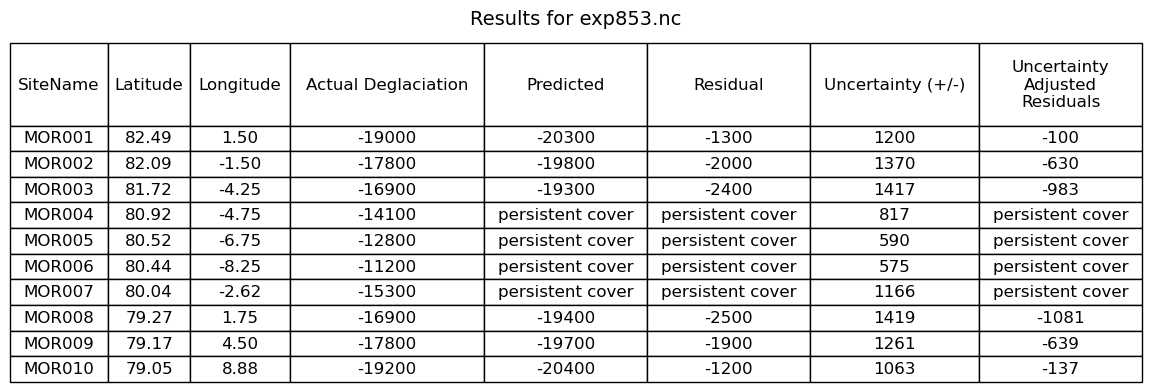

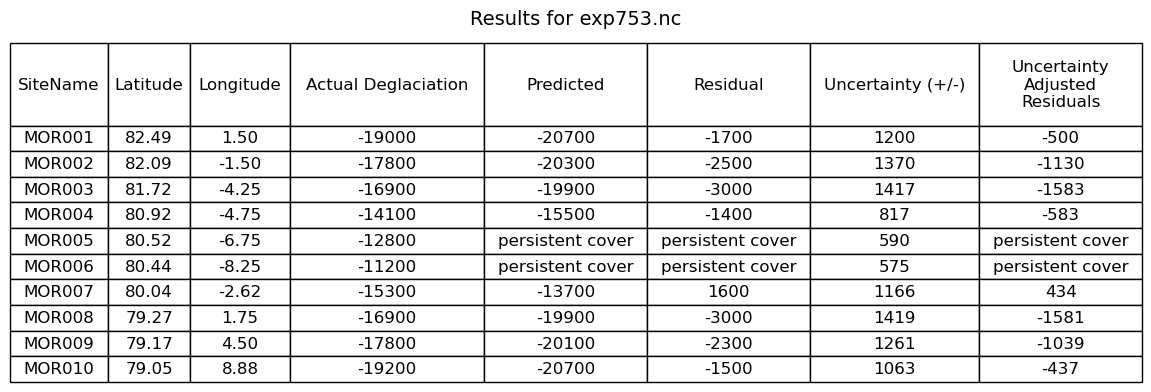

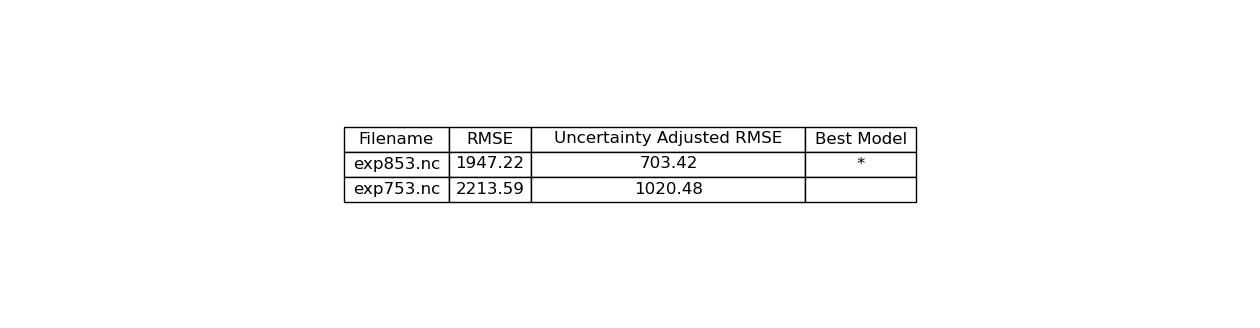

In [8]:
def find_contour_paths(lons, lats, data, contour_level):
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    
    # Create a RegularGridInterpolator for the data
    interpolator = RegularGridInterpolator((lats, lons), data, method='linear', bounds_error=False, fill_value=np.nan)
    
    # Generate interpolated data
    grid_points = np.array([lat_grid.flatten(), lon_grid.flatten()]).T
    interpolated_data = interpolator(grid_points).reshape(lat_grid.shape)
    
    # Smooth the data
    smoothed_data = gaussian_filter(interpolated_data, sigma=1)
    
    # Plot contours
    fig, ax = plt.subplots()
    CS = ax.contour(lon_grid, lat_grid, smoothed_data, levels=[contour_level])
    
    # Extract contour paths
    paths = []
    for i, level in enumerate(CS.levels):
        contour = CS.allsegs[i]
        for segment in contour:
            if len(segment) > 0:
                paths.append(np.array(segment))
    
    plt.close(fig)
    
    if paths:
        return paths[0]  # Return the first contour path
    return None

def find_nearest_point(lon, lat, path):
    path = np.array(path)
    distances = np.sqrt((path[:, 0] - lon)**2 + (path[:, 1] - lat)**2)
    min_index = np.argmin(distances)
    return path[min_index]

def find_sfc_with_most_nans(sfc_values, plot_var):
    max_nans = -1
    max_nans_sfc = None
    
    min_nans = float('inf')
    min_nans_sfc = None
    
    for sfc_value in sfc_values:
        index = np.where(sfc == sfc_value)[0][0]
        data_to_plot = np.where(plot_var[index, :, :] == 0, np.nan, plot_var[index, :, :])
        num_nans = np.isnan(data_to_plot).sum()
        
        if num_nans > max_nans:
            max_nans = num_nans
            max_nans_sfc = sfc_value
        
        if num_nans < min_nans:
            min_nans = num_nans
            min_nans_sfc = sfc_value
    
    return max_nans_sfc, min_nans_sfc

def calculate_deglaciation_year(marker_lat, marker_lon, sfc_values, lons, lats, plot_var, base):
    # Find the sfc values with the most and least NaNs
    sfc_most_nans, sfc_least_nans = find_sfc_with_most_nans(sfc_values, plot_var)
    
    min_contour_path = None
    max_contour_path = None
    
    for sfc_value in [sfc_most_nans, sfc_least_nans]:
        index = np.where(sfc == sfc_value)[0][0]
        data_to_plot = np.where(plot_var[index, :, :] == 0, np.nan, plot_var[index, :, :])
        
        # Replace NaNs with zeros for interpolation
        data_to_plot = np.nan_to_num(data_to_plot)
        
        contour_path = find_contour_paths(lons, lats, data_to_plot, contour_level=0.5)
        
        if contour_path is not None:
            if sfc_value == sfc_most_nans:
                max_contour_path = Path(contour_path)
            if sfc_value == sfc_least_nans:
                min_contour_path = Path(contour_path)

    # Check if marker is within the area defined by the min and max contours
    if min_contour_path is None or max_contour_path is None:
        return np.nan  # If contours couldn't be determined, return NaN

    if min_contour_path.contains_point((marker_lon, marker_lat)) and max_contour_path.contains_point((marker_lon, marker_lat)):
        return np.nan  # If the marker is outside the contours, return NaN

    # If the marker is inside the area, proceed with finding the best sfc value
    min_distance = float('inf')
    best_sfc = None

    for sfc_value in sfc_values:
        index = np.where(sfc == sfc_value)[0][0]
        data_to_plot = np.where(plot_var[index, :, :] == 0, np.nan, plot_var[index, :, :])
        
        # Replace NaNs with zeros for interpolation
        data_to_plot = np.nan_to_num(data_to_plot)
        
        contour_path = find_contour_paths(lons, lats, data_to_plot, contour_level=0.5)

        if contour_path is not None:
            nearest_point = find_nearest_point(marker_lon, marker_lat, contour_path)
            distance = np.sqrt((nearest_point[0] - marker_lon)**2 + (nearest_point[1] - marker_lat)**2)
            
            if distance < min_distance:
                min_distance = distance
                best_sfc = sfc_value
    
    return best_sfc

model_errors_dict = {}
rmse_dict = {}
uncertainty_adjusted_rmse_dict = {}  # Dictionary to store Uncertainty Adjusted RMSE

for filename, xrds in xrds_dict.items():
    lats = xrds.variables['lat'][:]
    lons = xrds.variables['lon'][:]
    plot_var = xrds.variables['plot variable'][:]
    base = xrds.variables['base'][:]
    sfc = xrds.variables['sfc'][:]

    cell_text = []
    model_errors = []  # List to collect model errors for averaging
    uncertainty_adjusted_residuals = []  # List to collect uncertainty adjusted residuals
    unique_sfc = np.unique(sfc)
    unique_sfc.sort()

    for i, row in excel.iterrows():
        marker_lat = row['Latitude']
        marker_lon = row['Longitude']

        deglaciation_year = calculate_deglaciation_year(marker_lat, marker_lon, unique_sfc, lons, lats, plot_var, base)

        # Calculate the model error
        actual_deglaciation = row['Age']
        model_error = deglaciation_year - actual_deglaciation

        # Calculate the uncertainty adjusted residual
        uncertainty = row['Uncertainty']
        if not np.isnan(model_error):
            if model_error < 0:
                uncertainty_adjusted_residual = model_error + uncertainty
                if uncertainty_adjusted_residual > 0:
                    uncertainty_adjusted_residual_str = "Perfect Fit"
                else:
                    uncertainty_adjusted_residual_str = f"{uncertainty_adjusted_residual:.0f}"
            else:
                uncertainty_adjusted_residual = model_error - uncertainty
                if uncertainty_adjusted_residual < 0:
                    uncertainty_adjusted_residual_str = "Perfect Fit"
                else:
                    uncertainty_adjusted_residual_str = f"{uncertainty_adjusted_residual:.0f}"

            # Append model_error to list if it's not NaN
            model_errors.append(model_error)
            uncertainty_adjusted_residuals.append(abs(uncertainty_adjusted_residual))
        else:
            uncertainty_adjusted_residual_str = "persistent cover"

        # Handle NaN by replacing it with 'persistent cover'
        deglaciation_year_str = f"{deglaciation_year:.0f}" if not np.isnan(deglaciation_year) else "persistent cover"
        model_error_str = f"{model_error:.0f}" if not np.isnan(model_error) else "persistent cover"

        # Append data to cell_text including the new column
        cell_text.append([row['SiteName'], f"{row['Latitude']:.2f}", f"{row['Longitude']:.2f}",
                          f"{row['Age']:.0f}", deglaciation_year_str, model_error_str, 
                          f"{row['Uncertainty']:.0f}", uncertainty_adjusted_residual_str])

    # Calculate the average model error
    avg_model_error = np.nanmean(model_errors) if model_errors else np.nan
    avg_model_error_rounded = round(avg_model_error, 2)
    model_errors_dict[filename] = avg_model_error_rounded

    # Calculate the RMSE for this file
    rmse = np.sqrt(np.nanmean(np.square(model_errors))) if model_errors else np.nan
    rmse_rounded = round(rmse, 2)
    rmse_dict[filename] = rmse_rounded

    # Calculate the Uncertainty Adjusted RMSE
    uncertainty_adjusted_rmse = np.sqrt(np.nanmean(np.square(uncertainty_adjusted_residuals))) if uncertainty_adjusted_residuals else np.nan
    uncertainty_adjusted_rmse_rounded = round(uncertainty_adjusted_rmse, 2)
    uncertainty_adjusted_rmse_dict[filename] = uncertainty_adjusted_rmse_rounded

    # Create table
    fig_table, ax_table = plt.subplots(figsize=(14, 4)) 
    ax_table.axis('tight')
    ax_table.axis('off')

    col_labels = [
        'SiteName', 'Latitude', 'Longitude', 'Actual Deglaciation', 
        'Predicted', 'Residual', 'Uncertainty (+/-)', 
        'Uncertainty\nAdjusted\nResiduals'
    ]

    table = ax_table.table(
        cellText=cell_text, 
        colLabels=col_labels,
        cellLoc='center', 
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    table.auto_set_column_width([0, 1, 2, 3, 4, 5, 6, 7])

    for i in range(len(col_labels)):
        cell = table[(0, i)] 
        cell.set_height(cell.get_height() * 3.2)
        cell.set_text_props(wrap=True)  

    for k, cell in table._cells.items():
        cell.set_edgecolor('black')
        cell.set_linewidth(1)
        cell._text.set_verticalalignment('center') 

    plt.title(f"Results for {filename}\n", fontsize=14, loc='center')
    plt.subplots_adjust(top=0.9)
    plt.show()

# Create a summary table for RMSE and Uncertainty Adjusted RMSE
summary_data = [
    (filename, rmse_dict.get(filename, np.nan), uncertainty_adjusted_rmse_dict.get(filename, np.nan))
    for filename in rmse_dict.keys()
]
summary_df = pd.DataFrame(summary_data, columns=['Filename', 'RMSE', 'Uncertainty Adjusted RMSE'])

# Add "Best Model" column based on RMSE
min_rmse = summary_df['Uncertainty Adjusted RMSE'].min()
summary_df['Best Model'] = ['*' if rmse == min_rmse else '' for rmse in summary_df['Uncertainty Adjusted RMSE']]

# Plot the summary table
fig_summary, ax_summary = plt.subplots(figsize=(16, 4))
ax_summary.axis('tight')
ax_summary.axis('off')

summary_table = ax_summary.table(cellText=summary_df.values, colLabels=summary_df.columns,
                                 cellLoc='center', loc='center')
summary_table.auto_set_font_size(False)
summary_table.set_fontsize(12)
summary_table.scale(1, 1.5)
summary_table.auto_set_column_width([0, 1, 2, 3])

for k, cell in summary_table._cells.items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1)
    cell._text.set_verticalalignment('center')

plt.show()

## **3.   Temporal Calving Front Evolution**

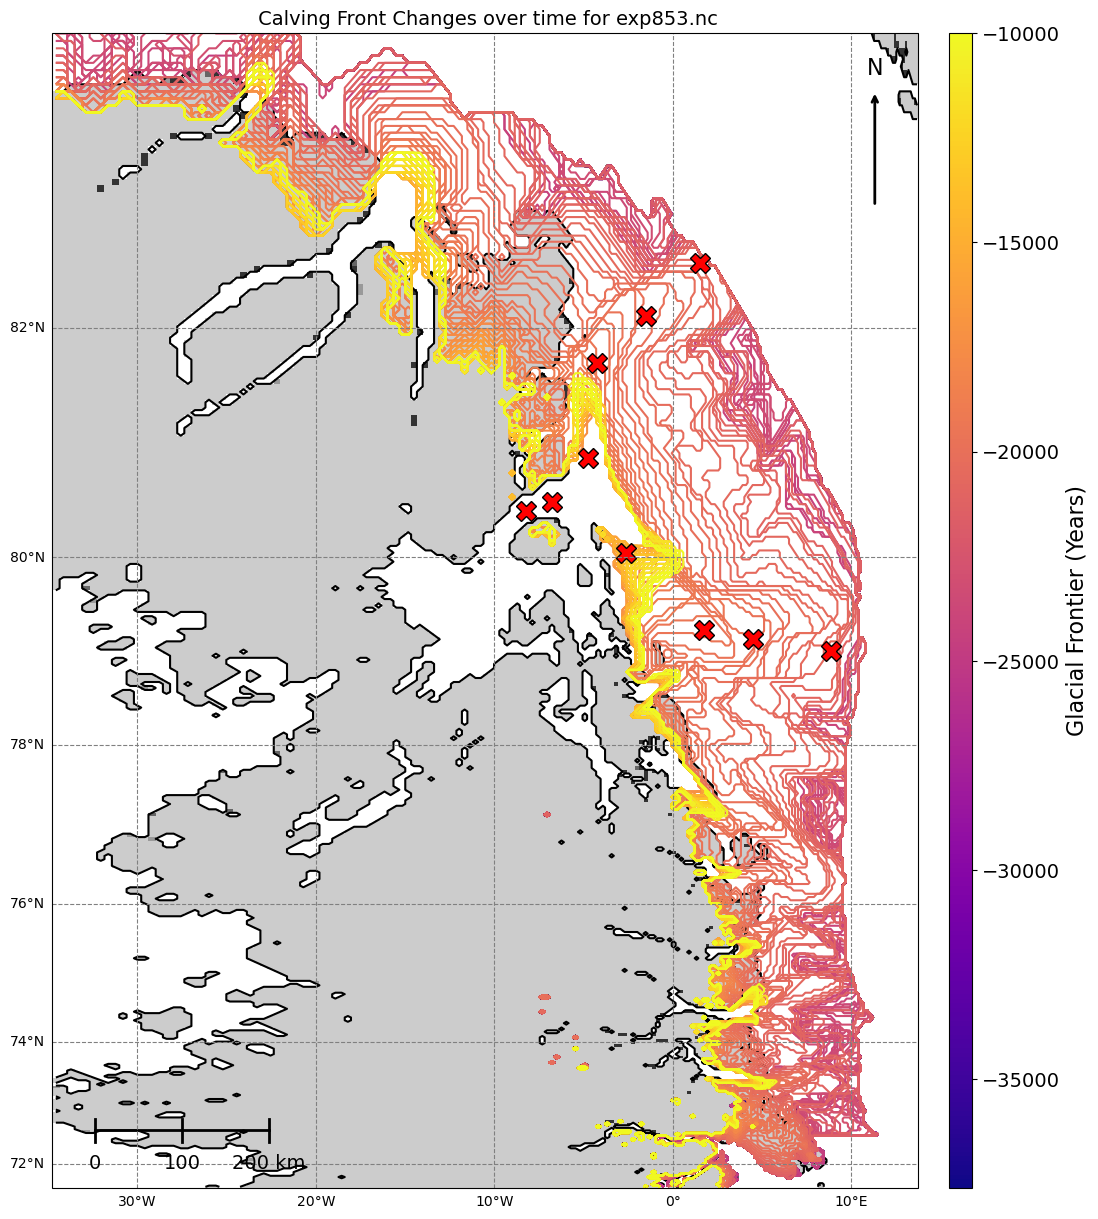

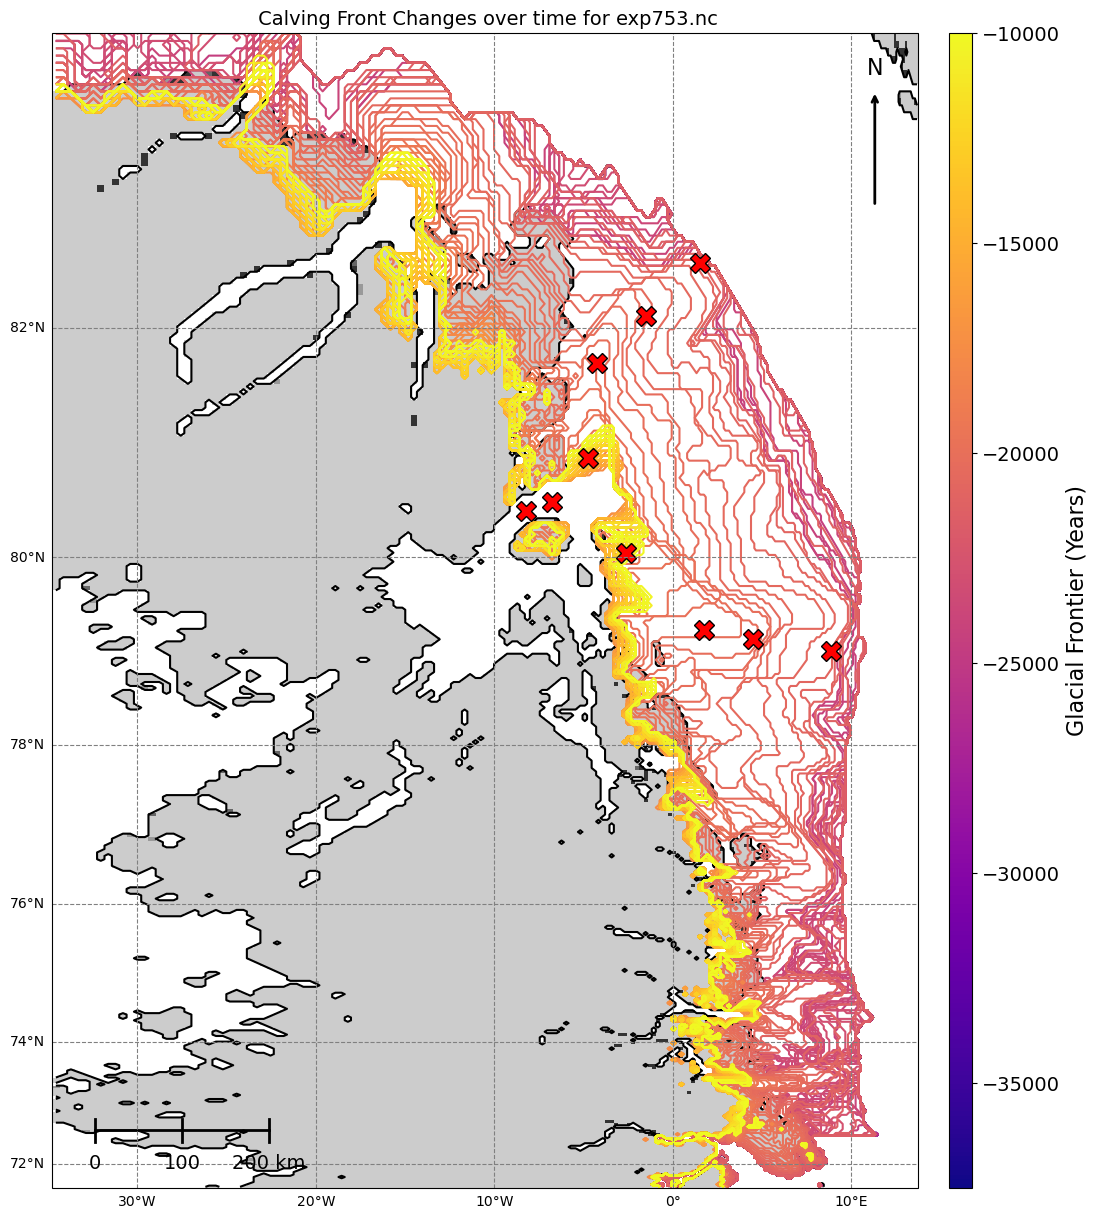

In [9]:
def create_interactive_plot(filename, xrds):
    # Extract variables from the dataset
    lats = xrds.variables['lat'][:]
    lons = xrds.variables['lon'][:]
    plot_var = xrds.variables['plot variable'][:]
    base = xrds.variables['base'][:]
    sfc = xrds.variables['sfc'][:]

    # Create a custom colormap that includes white for zero values
    cmap = plt.cm.jet
    cmap.set_bad(color='white')  # Set color for NaN values

    # Get the first `sfc` value
    sfc_value = sfc[0]

    # Convert data to NumPy array and mask zero values
    data_to_plot1 = np.array(np.squeeze(base[0, :, :]))
    data_to_plot1[data_to_plot1 == 0] = np.nan

    # Plotting configurations
    fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': ccrs.Mercator()})
    dark_grey_cmap = mcolors.ListedColormap(['#333333', '#666666', '#999999', '#CCCCCC'])
    bounds = [0, 0.1, 0.5, 1, np.nanmax(data_to_plot1)]
    norm = mcolors.BoundaryNorm(bounds, dark_grey_cmap.N)

    # Plot using pcolormesh
    pcolormesh1 = ax.pcolormesh(lons, lats, data_to_plot1, cmap=dark_grey_cmap, norm=norm, transform=ccrs.PlateCarree())

    contour_base = ax.contour(lons, lats, np.isnan(data_to_plot1).astype(int),
                              levels=[0.5], colors='black', 
                              transform=ccrs.PlateCarree())

    # Get the number of timesteps/layers in the sfc variable
    num_layers = sfc.shape[0]

    # Define a new colormap for the contours based on the sfc values
    contour_cmap = plt.cm.plasma
    norm_contour = mcolors.Normalize(vmin=sfc.min(), vmax=sfc.max())

    # Create a ScalarMappable to use with the color bar
    sm = plt.cm.ScalarMappable(cmap=contour_cmap, norm=norm_contour)
    sm.set_array([])  # Only needed for creating the color bar

    for val in range(num_layers):
        data_to_plot = np.array(np.squeeze(plot_var[val, :, :]))
        data_to_plot[data_to_plot == 0] = np.nan

        # Calculate color for this contour based on sfc value
        contour_color = contour_cmap(norm_contour(sfc[val]))

        contour_plot_var = ax.contour(lons, lats, np.isnan(data_to_plot).astype(int), 
                              levels=[0.5], colors=[contour_color], 
                              transform=ccrs.PlateCarree())

    # Add the color bar
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02, aspect=50)
    cbar.set_label('Glacial Frontier (Years)', fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    
    # Add the filename to the title
    plt.title(f" Calving Front Changes over time for {filename}", fontsize=14, loc='center')

    # Plot markers based on the duplicated_excel dataset
    for i, row in excel.iterrows():
        marker_lat = row['Latitude']
        marker_lon = row['Longitude']

        # Draw marker
        ax.plot(marker_lon, marker_lat, marker='X', color='red', markersize=15, 
                transform=ccrs.PlateCarree(), linestyle='None', markeredgecolor='black')

    # Customize gridlines to only show on left and bottom
    gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, color='gray', linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = True
    gl.bottom_labels = True

    # Add a north indicator (north arrow)
    north_arrow_position = (0.95, 0.95)
    arrowprops = dict(facecolor='black', edgecolor='black', arrowstyle='->', lw=2)
    ax.annotate('', xy=(north_arrow_position[0], north_arrow_position[1]), 
                xytext=(north_arrow_position[0], north_arrow_position[1] - 0.1),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=arrowprops)
    ax.text(north_arrow_position[0], north_arrow_position[1] + 0.01, 'N', 
            transform=ax.transAxes, ha='center', va='bottom', fontsize=16, color='black')

    # Scale bar
    scale_length_km = 200
    scale_length_deg = scale_length_km / 111
    scale_bar_position = (0.05, 0.05)
    scale_bar_length = 0.2
    scale_bar_height = 0.01

    scale_bar_start = scale_bar_position[0]
    scale_bar_end = scale_bar_start + scale_bar_length
    ax.plot([scale_bar_start, scale_bar_end], [scale_bar_position[1], scale_bar_position[1]], 
            transform=ax.transAxes, color='black', lw=2)

    tick_positions = [0, 0.5 * scale_bar_length, scale_bar_length]
    tick_labels = ['0', '100', '200 km']
    for tick_pos, label in zip(tick_positions, tick_labels):
        tick_x = scale_bar_start + tick_pos
        ax.plot([tick_x, tick_x], [scale_bar_position[1] - scale_bar_height, scale_bar_position[1] + scale_bar_height],
                transform=ax.transAxes, color='black', lw=2)
        ax.text(tick_x, scale_bar_position[1] - 0.02, label, transform=ax.transAxes, ha='center', va='top', fontsize=14, color='black')

    # Display the plot
    plt.show()

# Iterate over each dataset in the xrds_dict dictionary
for filename, xrds in xrds_dict.items():
    create_interactive_plot(filename, xrds)


## **4.   Cross-Sectional Analysis**

In [10]:
def create_interactive_plot_with_lat_lon(filename, xrds):
    # Function to plot the data for all sfc values with a new color map and color bar
    def plot_var_with_lat_and_lon_range(lat_value, lon_range):
        fig, ax = plt.subplots(figsize=(12, 8))

        # Define a new colormap and normalization
        cmap = plt.get_cmap('inferno')
        norm = mcolors.Normalize(vmin=np.nanmin(xrds['sfc'].values), vmax=np.nanmax(xrds['sfc'].values))

        # Get the latitude index corresponding to the selected latitude value
        lat_index = np.where(xrds['lat'].values == lat_value)[0][0]

        # Get the longitude range indices based on the selected longitude range
        lon_min, lon_max = lon_range
        lon_indices = np.where((xrds['lon'].values >= lon_min) & (xrds['lon'].values <= lon_max))[0]

        for sfc_index in range(len(xrds['sfc'])):
            plot_var_data = xrds['plot variable'].isel(sfc=sfc_index, lat=lat_index).values[lon_indices]
            lon_data = xrds['lon'].values[lon_indices]

            # Filter out NaN and 0 values in var_data
            valid_mask = (~np.isnan(plot_var_data)) & (plot_var_data != 0)
            filtered_var_data = plot_var_data[valid_mask]
            filtered_lon_data = lon_data[valid_mask]

            # Get color for the current sfc value
            color = cmap(norm(xrds['sfc'].values[sfc_index]))

            # Plot the data for the current sfc with the specified color
            if len(filtered_var_data) > 0:  # Only plot if there is valid data
                ax.plot(filtered_lon_data, filtered_var_data, color=color, label=f'sfc={xrds["sfc"].values[sfc_index]}')

        # Create a colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        cbar_ax = fig.add_axes([0.99, 0.1, 0.03, 0.8])
        cbar = plt.colorbar(sm, cax=cbar_ax)
        cbar.set_label('Years Ago')

        ax.set_xlabel('Longitude')
        ax.set_ylabel(var)
        ax.set_title(f' Longitude Cross-sectional Analysis for All Years (lat={round(lat_value, 3)})')
        ax.set_xlim(lon_min, lon_max)
        ax.grid(True)
        plt.show()

    # Function to update the longitude slider range based on the selected latitude
    def update_lon_slider_range(*args):
        lat_value = lat_slider.value
        lat_index = np.where(xrds['lat'].values == lat_value)[0][0]

        # Initialize lists to hold min and max longitudes
        all_filtered_lon_data = []

        for sfc_index in range(len(xrds['sfc'])):
            plot_var_data = xrds['plot variable'].isel(sfc=sfc_index, lat=lat_index).values
            lon_data = xrds['lon'].values

            # Filter out NaN and 0 values in var_data
            valid_mask = (~np.isnan(plot_var_data)) & (plot_var_data != 0)
            filtered_lon_data = lon_data[valid_mask]

            if len(filtered_lon_data) > 0:
                all_filtered_lon_data.extend(filtered_lon_data)

        # Determine the min and max longitude of the filtered data
        if len(all_filtered_lon_data) > 0:
            min_lon = min(all_filtered_lon_data)
            max_lon = max(all_filtered_lon_data)
            lon_slider.min = min_lon
            lon_slider.max = max_lon
            lon_slider.value = (min_lon, max_lon)

    # Create a slider widget for selecting latitude values
    lat_slider = widgets.SelectionSlider(
        options=xrds['lat'].values,
        value=xrds['lat'].values[0],
        description='Lat:',
        continuous_update=False
    )

    # Create a range slider widget for selecting the longitude range
    lon_slider = widgets.SelectionRangeSlider(
        options=xrds['lon'].values,
        value=(xrds['lon'].values[0], xrds['lon'].values[-1]),
        description='Lon Range:',
        continuous_update=False
    )

    # Update the longitude slider when the latitude slider value changes
    lat_slider.observe(update_lon_slider_range, 'value')

    # Display the sliders and the plot
    update_lon_slider_range()
    output = widgets.interactive_output(plot_var_with_lat_and_lon_range, {'lat_value': lat_slider, 'lon_range': lon_slider})
    
    print(f'Filename: {filename}')
    display(lat_slider, lon_slider, output)


# Iterate over each dataset in the xrds_dict dictionary
for filename, xrds in xrds_dict.items():
    create_interactive_plot_with_lat_lon(filename, xrds)

Filename: exp853.nc


SelectionSlider(continuous_update=False, description='Lat:', options=(71.60381106529074, 71.64696338146211, 71…

SelectionRangeSlider(continuous_update=False, description='Lon Range:', index=(0, 121), options=(-34.557825957…

Output()

Filename: exp753.nc


SelectionSlider(continuous_update=False, description='Lat:', options=(71.60381106529074, 71.64696338146211, 71…

SelectionRangeSlider(continuous_update=False, description='Lon Range:', index=(0, 151), options=(-34.557825957…

Output()

In [11]:
print(f"\033[1;92mYou have successfully ran BGMAT.\033[0m")

You have successfully ran BGMAT.
